In [1]:
import pandas as pd
import numpy as np
import json
import torch

#### Chargement des données

In [2]:
def load_dataset(file_path):
    with open(file_path, 'r') as f:
        dataset = json.load(f)
    return dataset

def load_test_set(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        test_data = f.readlines()
    return test_data

data_train = load_dataset("train.json")
data_test = load_test_set("test_shuffle.txt")

rows = []
for label, texts in data_train.items():
    for text in texts:
        rows.append({'label': label, 'text': text})

df_train = pd.DataFrame(rows)


labelised = True

if(labelised):
    data_test = load_test_set("test_label.txt")
    rows = []
    for data in data_test:
        label, text = data.split(',',1)
        rows.append({'label': label, 'text': text})
else:
    data_test = load_test_set("test_shuffle.txt")
    rows = []
    for data in data_test:
        rows.append({'text': data})


df_test = pd.DataFrame(rows)
df_test.head()

,label,text
0,Politics,The role of credit scores in lending decision...
1,Environment,The impact of overpopulation on the environme...
2,Science,The importance of the scientific method in co...
3,Finance,The startup accelerator provides funding and ...
4,Technology,"The benefits of biomimicry are many, includin..."


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train['label'] = le.fit_transform(df_train['label'])
df_test['label'] = le.transform(df_test['label'])

In [7]:
df_wiki = pd.read_csv('wiki_data.csv')
df_wiki['label'] = le.transform(df_wiki['label'])

In [9]:
df_wiki.head()

,label,text
0,0,Photo of primary school children sitting in an...
1,0,"Education is the transmission of knowledge, sk..."
2,0,Formal education occurs within a structured in...
3,0,Non-formal education also follows a structured...
4,0,Formal and non-formal education are categorize...


In [12]:
df_train_aug = pd.read_csv('train_augmented_M.csv')

print(df_train_aug['text'].apply(lambda x: len(x.split())).mean())

11.756944444444445


In [13]:
print(df_wiki['text'].apply(lambda x: len(x.split())).mean())

24.12052246190382


In [15]:
df_train = pd.concat([df_train_aug, df_wiki], ignore_index=True)

In [17]:
df_train

,label,text
0,7,The mayor announced a new initiative to improv...
1,7,The senator is facing criticism for her stance...
2,7,The upcoming election has sparked intense deba...
3,6,Regular exercise and a balanced diet are key t...
4,6,The World Health Organization has issued new g...
...,...,...
5192,11,: 23 There is now broad consensus that touris...
5193,11,The New York Times recently described the Gran...
5194,11,"It includes a set of sub-disciplines, and glob..."
5195,11,"Travel to Mount Everest, the Amazon rainforest..."


### Création du modèle

In [18]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [19]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [26]:
MAX_LEN = 30
BATCH_SIZE = 32
EPOCHS = 10

In [27]:

train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=12)

model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [28]:

losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        attention_mask = batch['attention_mask'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        labels = batch['label'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print(f'Training loss: {avg_train_loss:.4f}')

Epoch 1/10
Training loss: 1.9154
Epoch 2/10
Training loss: 0.7868
Epoch 3/10
Training loss: 0.4137
Epoch 4/10
Training loss: 0.2628
Epoch 5/10
Training loss: 0.1677
Epoch 6/10
Training loss: 0.1161
Epoch 7/10
Training loss: 0.0779
Epoch 8/10
Training loss: 0.0576
Epoch 9/10
Training loss: 0.0406
Epoch 10/10
Training loss: 0.0308


Matplotlib created a temporary cache directory at /tmp/matplotlib-dingrtoh because the default path (/home/thirsty_jackson/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


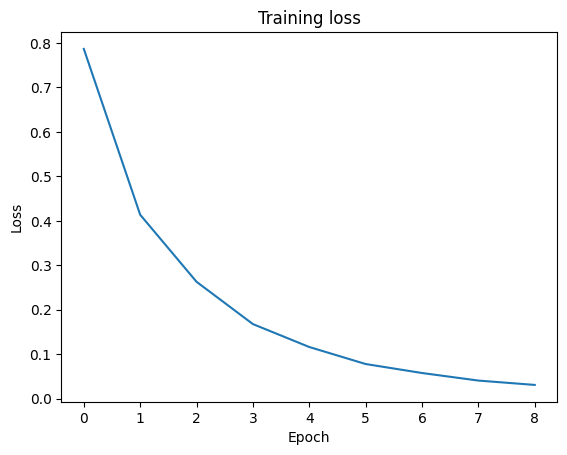

In [29]:
import matplotlib.pyplot as plt

plt.plot(losses[1::])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

### Evaluation du modèle

In [31]:
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model.eval()
predictions = []
true_labels = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    attention_mask = batch['attention_mask'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    labels = batch['label']
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7482


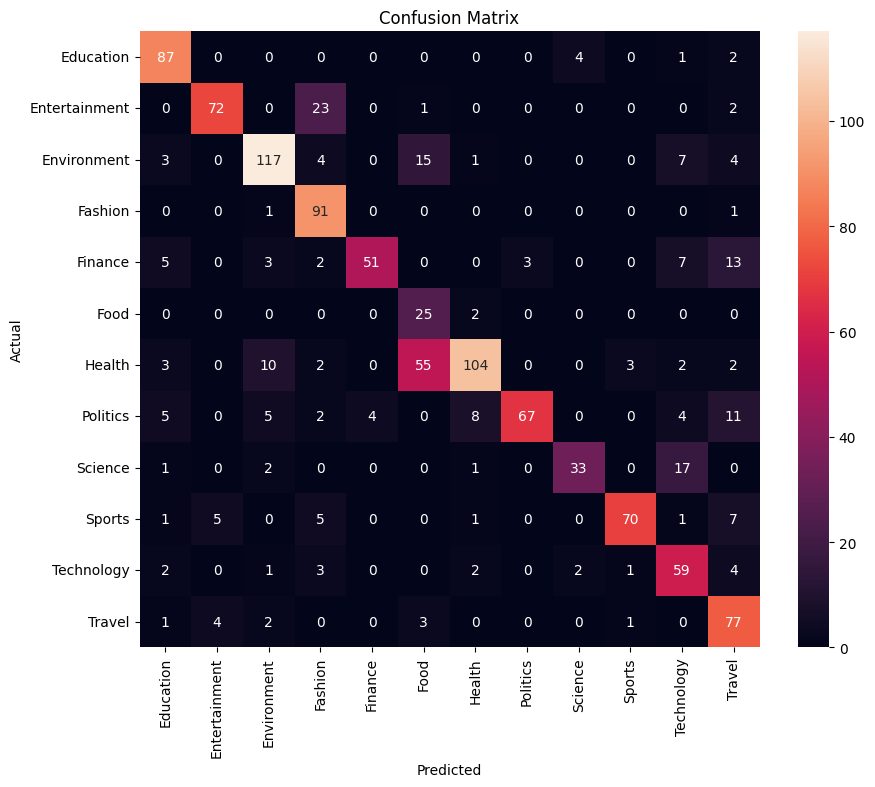

In [32]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [33]:
def copy_matrix_with_zero_diagonal(matrix):
    # Make a copy of the input matrix
    copied_matrix = np.copy(matrix)
    
    # Get the size of the matrix
    rows, cols = copied_matrix.shape
    
    # Set diagonal elements to zero
    for i in range(min(rows, cols)):
        copied_matrix[i, i] = 0
    
    return copied_matrix

In [34]:
cm_d = copy_matrix_with_zero_diagonal(cm)

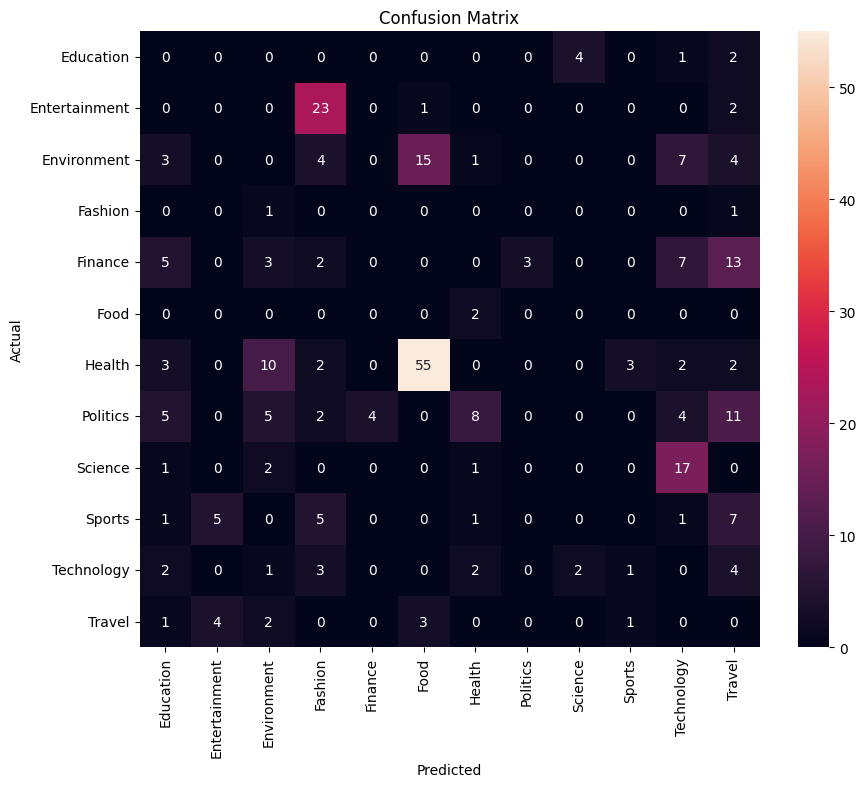

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_d, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Création du fichier à soumettre

In [36]:
df_test['label'] = predictions
df_test['label'] = le.inverse_transform(df_test['label'])
df_test.head()
df_test.drop('text', axis=1, inplace=True)
df_test['ID'] = df_test.index
df_test = df_test[['ID', 'label']]
df_test.to_csv('submission_test.csv', index=False)